In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2

In [6]:
dataset_dir = "/kaggle/input/arabic-letters-numbers-ocr/Dataset"

# Extract unique characters from directory names
unique_chars = set()
for label in os.listdir(dataset_dir):
    unique_chars.add(label)
# create a mapping for each char
label_to_index = {char: idx for idx, char in enumerate(sorted(unique_chars))}
print("Characters:", sorted(unique_chars))
print("Character to number mapping:", label_to_index)

Characters: ['ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'لا', 'م', 'ن', 'ه', 'و', 'ي', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩']
Character to number mapping: {'ا': 0, 'ب': 1, 'ت': 2, 'ث': 3, 'ج': 4, 'ح': 5, 'خ': 6, 'د': 7, 'ذ': 8, 'ر': 9, 'ز': 10, 'س': 11, 'ش': 12, 'ص': 13, 'ض': 14, 'ط': 15, 'ظ': 16, 'ع': 17, 'غ': 18, 'ف': 19, 'ق': 20, 'ك': 21, 'ل': 22, 'لا': 23, 'م': 24, 'ن': 25, 'ه': 26, 'و': 27, 'ي': 28, '٠': 29, '١': 30, '٢': 31, '٣': 32, '٤': 33, '٥': 34, '٦': 35, '٧': 36, '٨': 37, '٩': 38}


In [8]:
index_to_label = {v: k for k, v in label_to_index.items()}

In [ ]:
char_to_num = {char: idx for idx, char in enumerate(sorted(unique_chars))}
print("Characters:", sorted(unique_chars))
print("Character to number mapping:", char_to_num)

Characters: ['ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'لا', 'م', 'ن', 'ه', 'و', 'ي', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩']
Character to number mapping: {'ا': 0, 'ب': 1, 'ت': 2, 'ث': 3, 'ج': 4, 'ح': 5, 'خ': 6, 'د': 7, 'ذ': 8, 'ر': 9, 'ز': 10, 'س': 11, 'ش': 12, 'ص': 13, 'ض': 14, 'ط': 15, 'ظ': 16, 'ع': 17, 'غ': 18, 'ف': 19, 'ق': 20, 'ك': 21, 'ل': 22, 'لا': 23, 'م': 24, 'ن': 25, 'ه': 26, 'و': 27, 'ي': 28, '٠': 29, '١': 30, '٢': 31, '٣': 32, '٤': 33, '٥': 34, '٦': 35, '٧': 36, '٨': 37, '٩': 38}


In [ ]:
from PIL import Image

class ArabicDataset(Dataset):
    def __init__(self, dataset_dir, char_to_num, transform=None, target_size=(32, 32)):
        self.data = []
        self.labels = []
        self.transform = transform
        self.target_size = target_size  # Set target image size

        for folder in os.listdir(dataset_dir):
            folder_path = os.path.join(dataset_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if not file_path.endswith(('.png', '.jpg', '.jpeg')):
                    continue
                img = Image.open(file_path).convert("L")  # Convert to grayscale
                img = img.resize(self.target_size)  # Resize to target size
                img = np.array(img)  # Convert to NumPy array
                self.data.append(img)
                self.labels.append(char_to_num[folder])

        # Normalize images and convert to consistent shape
        self.data = np.array(self.data) / 255.0  # Normalize images to [0, 1]
        self.data = np.expand_dims(self.data, axis=-1)  # Add channel dimension
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:

# Load dataset
dataset = ArabicDataset(dataset_dir, char_to_num, transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ResNet-inspired model
class ArabicOCRModel(nn.Module):
    def __init__(self, num_classes):
        super(ArabicOCRModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.residual_block = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        residual = x
        x = self.residual_block(x)
        x += residual  # Add residual connection
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ArabicOCRModel(num_classes=len(unique_chars)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    train_accuracy = correct / len(train_dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device).float(), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
    val_accuracy = val_correct / len(val_dataset)

    print(f"Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Test the model
model.eval()
test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device).float(), labels.to(device)
        outputs = model(images)
        test_correct += (outputs.argmax(1) == labels).sum().item()
test_accuracy = test_correct / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10, Train Accuracy: 0.9334, Val Accuracy: 0.9924
Epoch 2/10, Train Accuracy: 0.9825, Val Accuracy: 0.9948
Epoch 3/10, Train Accuracy: 0.9883, Val Accuracy: 0.9966
Epoch 4/10, Train Accuracy: 0.9893, Val Accuracy: 0.9946
Epoch 5/10, Train Accuracy: 0.9919, Val Accuracy: 0.9966
Epoch 6/10, Train Accuracy: 0.9941, Val Accuracy: 0.9974
Epoch 7/10, Train Accuracy: 0.9946, Val Accuracy: 0.9973
Epoch 8/10, Train Accuracy: 0.9947, Val Accuracy: 0.9969
Epoch 9/10, Train Accuracy: 0.9949, Val Accuracy: 0.9979
Epoch 10/10, Train Accuracy: 0.9959, Val Accuracy: 0.9977
Test Accuracy: 0.9970


In [52]:
test_accuracy

0.997037139116654

Classification Report:
              precision    recall  f1-score   support

           ا       1.00      1.00      1.00       368
           ب       1.00      0.97      0.98       372
           ت       0.99      0.99      0.99       378
           ث       1.00      0.99      0.99       409
           ج       1.00      1.00      1.00       359
           ح       0.99      1.00      0.99       366
           خ       1.00      1.00      1.00       381
           د       1.00      1.00      1.00       369
           ذ       1.00      1.00      1.00       368
           ر       1.00      0.99      1.00       342
           ز       1.00      1.00      1.00       379
           س       1.00      1.00      1.00       383
           ش       1.00      1.00      1.00       348
           ص       0.99      1.00      1.00       348
           ض       1.00      1.00      1.00       358
           ط       1.00      1.00      1.00       345
           ظ       1.00      1.00      1.00       372
    

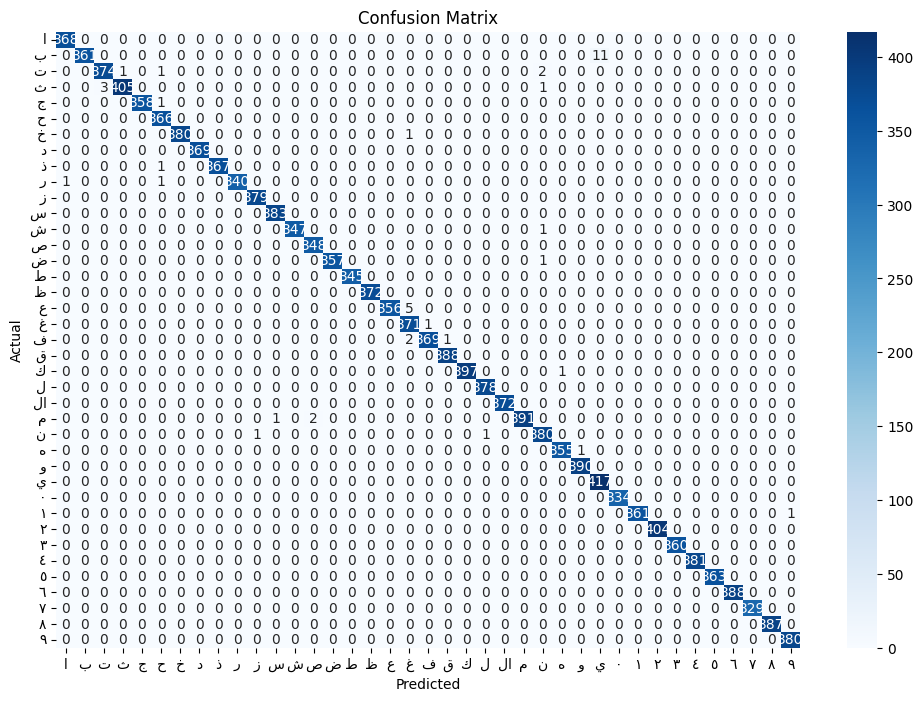

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Compute confusion matrix and classification report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device).float(), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=unique_chars))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=unique_chars, yticklabels=unique_chars, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [54]:
import onnx
import torch.onnx

onnx_model_path = "arabic_ocr2.onnx"
dummy_input = torch.randn(1, 1, 32, 32).to(device)  # Dummy input for ONNX conversion
torch.onnx.export(
    model, 
    dummy_input, 
    onnx_model_path, 
    input_names=["input"], 
    output_names=["output"], 
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)
print(f"Model converted to ONNX and saved at {onnx_model_path}")


Model converted to ONNX and saved at arabic_ocr2.onnx


In [ ]:
import onnxruntime as ort

# Load ONNX model
ort_session = ort.InferenceSession(onnx_model_path)

def predict_with_onnx(image):
    # Ensure the image has the correct shape: (1, 1, 32, 32)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    if image.shape[1] != 1:  # Ensure channel dimension is 1 (grayscale)
        image = np.expand_dims(image, axis=1)
    image = image.astype(np.float32)  # Convert to float32
    outputs = ort_session.run(None, {"input": image})
    predicted_class = np.argmax(outputs[0])  # Get the class with the highest score
    return predicted_class


In [47]:
# Test ONNX inference
test_sample, test_label = test_dataset[1]  # Get a sample from test dataset
predicted_class = predict_with_onnx(test_sample.numpy())
print(f"Actual: {unique_chars[test_label]}, Predicted: {unique_chars[predicted_class]}")

Actual: ز, Predicted: ز
